## 1. Loading Data

In [32]:
import os

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

In [33]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [34]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [46]:
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

def create_dataloader(data_dir: str,
                      transform: transforms.Compose,
                      batch_size: int=BATCH_SIZE,
                      num_workers: int=NUM_WORKERS,
                      shuffle=True):
    
    data = datasets.ImageFolder(data_dir, transform=transform)
   
    class_names = data.classes
    
    data_loader = DataLoader(data,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers=num_workers,
                            pin_memory=True)

    return data_loader, class_names

In [52]:
from pathlib import Path

data_path = Path("/kaggle/input/banglalekhaisolated")
image_path = data_path / "BanglaLekhaIsolated_inverted/BanglaLekhaIsolated"

In [53]:
train_dir = image_path / "train"
test_dir = image_path / "test"
val_dir = image_path / "val"

## 2. Importing Model

In [8]:
# import timm

# model = timm.create_model('maxvit_base_tf_512.in21k_ft_in1k', pretrained=True)

In [54]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
char_model = torchvision.models.efficientnet_b0(weights=weights)

#model # uncomment to output (it's very long)

In [10]:
# data_config = timm.data.resolve_model_data_config(model)
# train_transforms = timm.data.create_transform(**data_config, is_training=True)
# eval_transforms = timm.data.create_transform(**data_config, is_training=False)

In [55]:
# Get the transforms used to create our pretrained weights
train_transforms = eval_transforms = weights.transforms()

### 3. Transforming Data

In [56]:
train_dataloader, class_names = create_dataloader(data_dir=train_dir, transform=train_transforms)
val_dataloader, _ = create_dataloader(data_dir=val_dir, transform=eval_transforms, shuffle=False)
test_dataloader, _ = create_dataloader(data_dir=test_dir, transform=eval_transforms, shuffle=False)

In [57]:
class_names

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '3',
 '30',
 '31',
 '32',
 '33',
 '34',
 '35',
 '36',
 '37',
 '38',
 '39',
 '4',
 '40',
 '41',
 '42',
 '43',
 '44',
 '45',
 '46',
 '47',
 '48',
 '49',
 '5',
 '50',
 '51',
 '52',
 '53',
 '54',
 '55',
 '56',
 '57',
 '58',
 '59',
 '6',
 '60',
 '61',
 '62',
 '63',
 '64',
 '65',
 '66',
 '67',
 '68',
 '69',
 '7',
 '70',
 '71',
 '72',
 '73',
 '74',
 '75',
 '76',
 '77',
 '78',
 '79',
 '8',
 '80',
 '81',
 '82',
 '83',
 '84',
 '9']

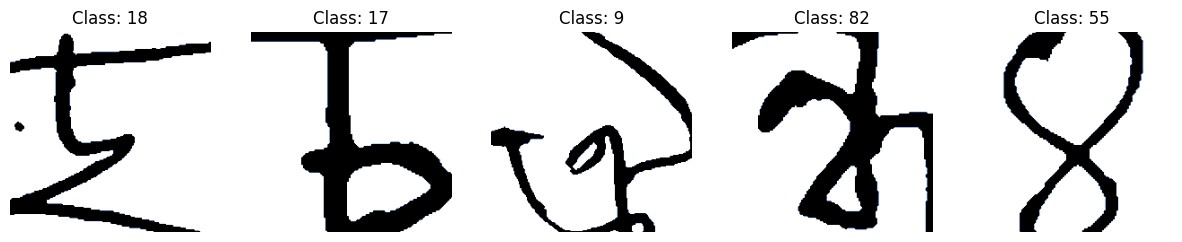

In [58]:
import matplotlib.pyplot as plt

# Get one batch of data from the train_dataloader
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

# Number of samples to display
num_samples = 5

# Display the first `num_samples` images along with their labels
fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
for i in range(num_samples):
    # Select the image and label
    img = images[i].permute(1, 2, 0)  # Change the order of dimensions from (C, H, W) to (H, W, C)
    label = labels[i].item()  # Get the label index as an integer
    
    # Display the image
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(f'Class: {class_names[label]}')

plt.show()


### 4. Changing the model head

In [14]:
# '''Freezing the parameters'''
# for param in model.parameters():
#     param.requires_grad = False

In [60]:
char_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [61]:
output_shape = len(class_names)
char_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True), 
    torch.nn.Linear(in_features=1280, 
                    out_features=output_shape, 
                    bias=True))

In [17]:
# model.head.fc = nn.Linear(in_features=768, out_features=len(class_names))
# model.head

In [18]:
# PATH = '/kaggle/input/banglacharrecognition/models/best_model.pth'
# model.load_state_dict(torch.load(PATH))

In [62]:
summary(char_model, 
        input_size=(32, 3, 512, 512), # (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 512, 512]    [32, 84]             --                   True
├─Sequential (features)                                      [32, 3, 512, 512]    [32, 1280, 16, 16]   --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 512, 512]    [32, 32, 256, 256]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 512, 512]    [32, 32, 256, 256]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 256, 256]   [32, 32, 256, 256]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 256, 256]   [32, 32, 256, 256]   --                   --
│    └─Sequential (1)                                        [32, 32, 256, 256]   [32, 16, 256

In [63]:
char_model = char_model.to(device)

### 5. Defining loss and optimizer

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

### 6. Perfomance metrics

In [22]:
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from torchmetrics import Metric

class PerformanceMetric:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)
        self.precision = Precision(task="multiclass", num_classes=num_classes, average='macro')
        self.recall = Recall(task="multiclass", num_classes=num_classes, average='macro')
        self.f1 = F1Score(task="multiclass", num_classes=num_classes, average='macro')
        self.confusion_matrix = ConfusionMatrix(task="multiclass", num_classes=num_classes)

    def update(self, predictions, targets):
        self.accuracy.update(predictions, targets)
        self.precision.update(predictions, targets)
        self.recall.update(predictions, targets)
        self.f1.update(predictions, targets)
        self.confusion_matrix.update(predictions, targets)

    def compute(self):
        accuracy = self.accuracy.compute().item()
        precision = self.precision.compute().item()
        recall = self.recall.compute().item()
        f1 = self.f1.compute().item()
        confusion_matrix = self.confusion_matrix.compute().cpu()

        return accuracy, precision, recall, f1, confusion_matrix

    def reset(self):
        self.accuracy.reset()
        self.precision.reset()
        self.recall.reset()
        self.f1.reset()
        self.confusion_matrix.reset()


### 7. Training

In [23]:
# !pip install torchmetrics

In [24]:
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

In [25]:
def train_step(model: torch.nn.Module, 
               num_classes: int,
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    
    model.train()
    
    train_loss = 0    
    metrics = PerformanceMetric(num_classes)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()        
        loss.backward()        
        optimizer.step()
        
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        
        metrics.update(y_pred_class.cpu(), y.cpu())

    train_loss = train_loss / len(dataloader)
    train_acc, train_precision, train_recall, train_f1, train_confusion_matrix = metrics.compute()
    
    metrics.reset()
    
    return train_loss, train_acc, train_precision, train_recall, train_f1, train_confusion_matrix

In [26]:
def test_step(model: torch.nn.Module, 
              num_classes: int,
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module,
              device: torch.device):

    model.eval()
    
    test_loss = 0
    metrics = PerformanceMetric(num_classes)

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            test_pred_logits = model(X)

            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            test_pred_labels = test_pred_logits.argmax(dim=1)
            metrics.update(test_pred_labels.cpu(), y.cpu())

    test_loss = test_loss / len(dataloader)
    test_acc, test_precision, test_recall, test_f1, test_confusion_matrix = metrics.compute()
    
    metrics.reset()
    
    return test_loss, test_acc, test_precision, test_recall, test_f1, test_confusion_matrix

In [27]:
from pathlib import Path

def save_model(model: torch.nn.Module, target_dir: str, model_name: str):
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

  
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

In [28]:
def train(model: torch.nn.Module,
          num_classes: int,
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):
    
    results = {"train_loss": [], "train_acc": [], "train_precision": [], "train_recall": [], "train_f1": [],
              "test_loss": [], "test_acc": [], "test_precision": [], "test_recall": [], "test_f1": []}
    
    curr_best_model = model
    curr_loss = 0
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc, train_precision, train_recall, train_f1, train_confusion_matrix = train_step(model=model,
                                                                                                        num_classes=num_classes,
                                                                                                        dataloader=train_dataloader,
                                                                                                        loss_fn=loss_fn,
                                                                                                        optimizer=optimizer,
                                                                                                        device=device)
        test_loss, test_acc, test_precision, test_recall, test_f1, test_confusion_matrix = test_step(model=model,
                                                                                                        num_classes=num_classes,
                                                                                                        dataloader=test_dataloader,
                                                                                                        loss_fn=loss_fn,
                                                                                                        device=device)
        
        if test_loss < curr_loss:
            curr_best_model = model
            curr_loss = test_loss

        print(f"Epoch: {epoch+1} | " 
                f"train_loss: {train_loss:.4f} | " 
                f"train_acc: {train_acc:.4f} | " 
                f"test_loss: {test_loss:.4f} | " 
                f"test_acc: {test_acc:.4f}")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["train_precision"].append(train_precision)
        results["train_recall"].append(train_recall)
        results["train_f1"].append(train_f1)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
        results["test_precision"].append(test_precision)
        results["test_recall"].append(test_recall)
        results["test_f1"].append(test_f1)
        
    save_model(model=curr_best_model, target_dir='models', model_name='best_model.pth')

    return results

In [30]:
EPOCHS = 15

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

results = train(model=model,
                num_classes=len(class_names),
                train_dataloader=train_dataloader,
                test_dataloader=val_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=EPOCHS,
                device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.5067 | train_acc: 0.8614 | test_loss: 0.3442 | test_acc: 0.9051
Epoch: 2 | train_loss: 0.3041 | train_acc: 0.9148 | test_loss: 0.2853 | test_acc: 0.9227
Epoch: 3 | train_loss: 0.2555 | train_acc: 0.9283 | test_loss: 0.2671 | test_acc: 0.9300
Epoch: 4 | train_loss: 0.2266 | train_acc: 0.9351 | test_loss: 0.2648 | test_acc: 0.9295
Epoch: 5 | train_loss: 0.2007 | train_acc: 0.9427 | test_loss: 0.2617 | test_acc: 0.9314
Epoch: 6 | train_loss: 0.1797 | train_acc: 0.9476 | test_loss: 0.2505 | test_acc: 0.9357
Epoch: 7 | train_loss: 0.1603 | train_acc: 0.9522 | test_loss: 0.2576 | test_acc: 0.9316
Epoch: 8 | train_loss: 0.1439 | train_acc: 0.9573 | test_loss: 0.2654 | test_acc: 0.9333
Epoch: 9 | train_loss: 0.1296 | train_acc: 0.9607 | test_loss: 0.2799 | test_acc: 0.9328
Epoch: 10 | train_loss: 0.1169 | train_acc: 0.9639 | test_loss: 0.2749 | test_acc: 0.9320
Epoch: 11 | train_loss: 0.1062 | train_acc: 0.9671 | test_loss: 0.2899 | test_acc: 0.9314
Epoch: 12 | train_l

### 7. saving the metrics

In [31]:
import csv
file_path = 'train_metrics_new.csv'

with open(file_path, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)   

In [32]:
# import shutil

# source_file = '/kaggle/input/banglacharrecognition/train_metrics.csv'
# destination_file = '/kaggle/working/train_metrics.csv'

# shutil.copyfile(source_file, destination_file)

In [33]:
import csv

headers = list(results.keys())

epoch_result = [list(col) for col in zip(*results.values())]

file_path = 'train_metrics_new.csv'

with open(file_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)
    writer.writerows(epoch_result)

In [35]:
test_loss, test_acc, test_precision, test_recall, test_f1, test_confusion_matrix = test_step(model=model,
                                                                                            num_classes=len(class_names),
                                                                                            dataloader=test_dataloader,
                                                                                            loss_fn=loss_fn,
                                                                                            device=device)

In [36]:
PATH = 'test_metrics_new.txt'
with open(PATH, 'w') as fp:
    fp.write(f'Test Loss: {test_loss}\n')
    fp.write(f'Test Accuracy: {test_acc}\n')
    fp.write(f'Test Precision: {test_precision}\n')
    fp.write(f'Test Recall: {test_recall}\n')
    fp.write(f'Test F1 Score: {test_f1}\n')
    fp.write(f'Test Confusion Matrix: \n{test_confusion_matrix.numpy()}\n')

### 8. Loading the best model

In [64]:
PATH = '/kaggle/input/best-model/best_model_new.pth'
char_model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [65]:
bangla_mapping = {
    1: 'অ',  2: 'আ',  3: 'ই',  4: 'ঈ',  5: 'উ',
    6: 'ঊ',  7: 'ঋ',  8: 'এ',  9: 'ঐ', 10: 'ও',
    11: 'ঔ', 12: 'ক', 13: 'খ', 14: 'গ', 15: 'ঘ',
    16: 'ঙ', 17: 'চ', 18: 'ছ', 19: 'জ', 20: 'ঝ',
    21: 'ঞ', 22: 'ট', 23: 'ঠ', 24: 'ড', 25: 'ঢ',
    26: 'ণ', 27: 'ত', 28: 'থ', 29: 'দ', 30: 'ধ',
    31: 'ন', 32: 'প', 33: 'ফ', 34: 'ব', 35: 'ভ',
    36: 'ম', 37: 'য', 38: 'র', 39: 'ল', 40: 'শ',
    41: 'ষ', 42: 'স', 43: 'হ', 44: 'ড়', 45: 'ঢ়',
    46: 'য়', 47: 'ৎ', 48: 'ং', 49: 'ঃ', 50: 'ঁ',
    51: '০', 52: '১', 53: '২', 54: '৩', 55: '৪',
    56: '৫', 57: '৬', 58: '৭', 59: '৮', 60: '৯',
    61: 'ক্ষ', 62: 'ব্দ', 63: 'ঙ্গ', 64: 'স্ক', 65: 'স্ফ',
    66: 'স্থ', 67: 'চ্ছ', 68: 'ক্ত', 69: 'স্ন', 70: 'ষ্ণ',
    71: 'ম্প', 72: 'হ্ম', 73: 'প্ত', 74: 'ম্ব', 75: 'ণ্ড',
    76: 'দ্ভ', 77: 'ত্থ', 78: 'ষ্ঠ', 79: 'ল্প', 80: 'ষ্প',
    81: 'ন্দ', 82: 'ন্ধ', 83: 'ম্ম', 84: 'ন্ঠ'
}


16579


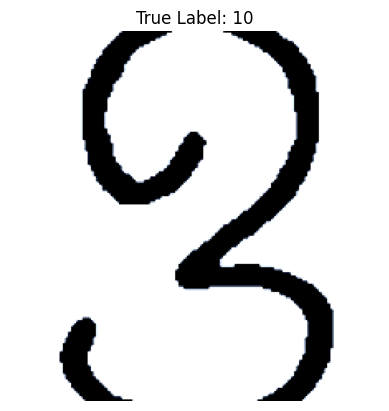

Predicted Class: 10
Predicted Alphabet: ও


In [66]:
import matplotlib.pyplot as plt
import torch


# Get the Dataset object from the DataLoader
dataset = test_dataloader.dataset
print(len(dataset))
# Calculate the index of the middle image
# middle_index = len(dataset) // 2

# Retrieve the image and label from the dataset using the calculated index
sample_image, sample_label = dataset[347]



# Step 2: Display the image using matplotlib
# If the image was normalized during the transforms, we might need to un-normalize it
# Assuming normalization was done using mean and std [0.5, 0.5, 0.5]
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

# Un-normalize the image
sample_image_unorm = sample_image * std[:, None, None] + mean[:, None, None]

# Convert the image from (C, H, W) to (H, W, C) for displaying
sample_image_unorm = sample_image_unorm.permute(1, 2, 0)

# Display the image
plt.imshow(sample_image_unorm)
plt.title(f"True Label: {class_names[sample_label]}")
plt.axis('off')
plt.show()

# Step 3: Make a prediction using the model
# Move the image to the appropriate device
sample_image = sample_image.to(device)

# Add a batch dimension (1, C, H, W)
sample_image = sample_image.unsqueeze(0)

# Set the model to evaluation mode and make a prediction
char_model.eval()
with torch.inference_mode():
    logits = char_model(sample_image)
    predicted_class_idx = logits.argmax(dim=1).item()

# Step 4: Display the predicted class
predicted_class_name = class_names[predicted_class_idx]
print(f"Predicted Class: {predicted_class_name}")
print(f"Predicted Alphabet: {bangla_mapping[int(predicted_class_name)]}")


## 1. Loading the best box detection model

In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 873.6/873.6 kB 15.4 MB/s eta 0:00:00a 0:00:01



image 1/1 /kaggle/input/best-model/sample_new.jpg: 352x640 3 inclined_tabless, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 352, 640)


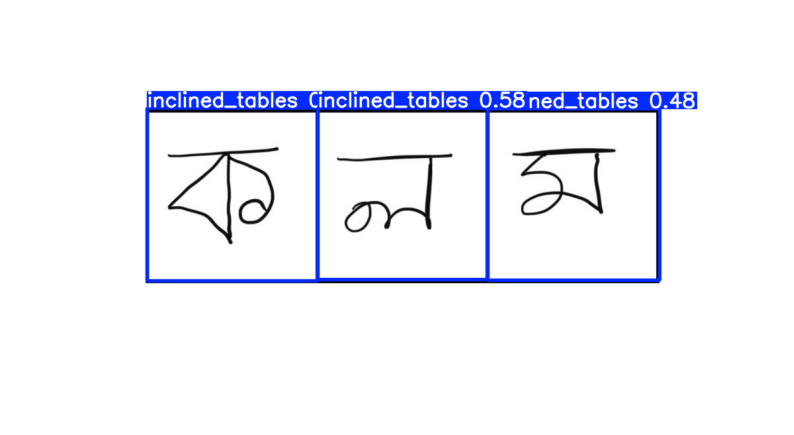

In [37]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2

# Load the trained model
model_path = '/kaggle/input/best-model/best_yolo.pt'
box_model = YOLO(model_path)

# Perform inference on an image
image_path = '/kaggle/input/best-model/sample_new.jpg'
results = box_model(image_path)  

# Save the results with annotations
results_path = results[0].plot()  # This saves the annotated image as a numpy array

# Display the results using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(results_path, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [24]:
# from ultralytics import YOLO

# # Load the trained model
# model_path = '/kaggle/input/best-model/best_yolo.pt'
# box_model = YOLO(model_path)

# # Perform inference on an image
# image_path = '/kaggle/input/best-model/sample_new.jpg'
# results = model(image_path)

# # print(results[1])

# # Access detected objects' bounding box coordinates
# for detection in results[0].boxes:
#     # Print the class, confidence, and bounding box coordinates
#     class_id = int(detection.cls)
#     confidence = detection.conf
#     bbox = detection.xyxy[0].cpu().numpy()  # Convert tensor to numpy array if needed

#     print(f"Class ID: {class_id}, Confidence: {confidence}")
#     print(f"Bounding Box Coordinates: {bbox}")  # [xmin, ymin, xmax, ymax]



image 1/1 /kaggle/input/best-model/sample_new.jpg: 352x640 3 inclined_tabless, 21.3ms
Speed: 1.8ms preprocess, 21.3ms inference, 1.2ms postprocess per image at shape (1, 3, 352, 640)
Class ID: 0, Confidence: tensor([0.5844], device='cuda:0')
Bounding Box Coordinates: [     465.35      149.08       722.5      408.22]
Class ID: 0, Confidence: tensor([0.4780], device='cuda:0')
Bounding Box Coordinates: [     722.98      150.14      982.04      409.09]
Class ID: 0, Confidence: tensor([0.4634], device='cuda:0')
Bounding Box Coordinates: [     207.46      149.17      465.46      410.23]


In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
char_model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat


image 1/1 /kaggle/input/best-model/sample_new.jpg: 352x640 3 inclined_tabless, 19.5ms
Speed: 2.8ms preprocess, 19.5ms inference, 1.4ms postprocess per image at shape (1, 3, 352, 640)
xmin: 207, ymin: 149, xmax: 465, ymax: 410
Saved cropped image: cropped_image_1.jpg


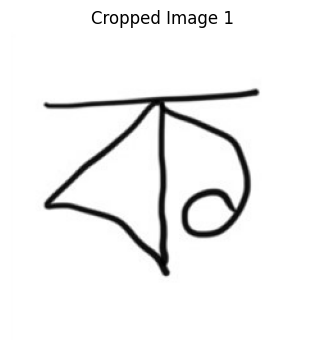

Predicted Class: 12
Predicted Alphabet: ক
xmin: 465, ymin: 149, xmax: 722, ymax: 408
Saved cropped image: cropped_image_2.jpg


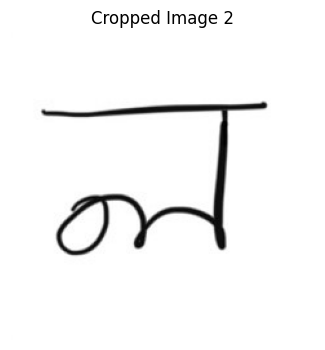

Predicted Class: 39
Predicted Alphabet: ল
xmin: 722, ymin: 150, xmax: 982, ymax: 409
Saved cropped image: cropped_image_3.jpg


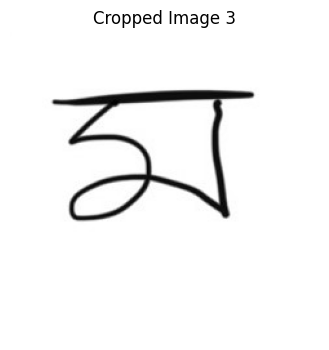

Predicted Class: 31
Predicted Alphabet: ন
Predicted Letter: কলন


In [84]:
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torchvision import transforms

# Load the trained model
model_path = '/kaggle/input/best-model/best_yolo.pt'
box_model = YOLO(model_path)

# Perform inference on an image
image_path = '/kaggle/input/best-model/sample_new.jpg'
results = box_model(image_path)

# Open the original image
original_image = Image.open(image_path)

# Define transformation for the cropped images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to the input size of your model
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalization (if required)
])

# Extract and sort detections based on xmin (left-most x-coordinate)
detections = results[0].boxes
sorted_detections = sorted(detections, key=lambda d: d.xyxy[0][0].item())  # Sort by xmin

predicted_letter=''
# Loop through sorted detections and crop each one
for i, detection in enumerate(sorted_detections):
    # Extract bounding box coordinates
    xmin, ymin, xmax, ymax = map(int, detection.xyxy[0].tolist())
    print(f"xmin: {xmin}, ymin: {ymin}, xmax: {xmax}, ymax: {ymax}")

    # Crop the image using the bounding box coordinates
    cropped_image = original_image.crop((xmin+5, ymin+15, xmax-15, ymax-5))
    
    # Convert cropped image to tensor and add batch dimension
    cropped_tensor = transform(cropped_image).unsqueeze(0)  # Shape: [1, 3, 224, 224]

    # Save or display the cropped image
    cropped_image_path = f'cropped_image_{i+1}.jpg'  # Use i+1 for sequential numbering
    cropped_image.save(cropped_image_path)
    print(f"Saved cropped image: {cropped_image_path}")

    # Display the cropped image
    plt.figure(figsize=(4, 4))
    plt.imshow(cropped_image)
    plt.axis('off')
    plt.title(f'Cropped Image {i+1}')
    plt.show()

    # Set the character model to evaluation mode
    char_model.eval()
    cropped_tensor = cropped_tensor.to(device)
    with torch.no_grad():
        logits = char_model(cropped_tensor)  # Forward pass

    # Get the predicted class index
    predicted_class_idx = logits.argmax(dim=1).item()

    # Display the predicted class
    predicted_class_name = class_names[predicted_class_idx]
    print(f"Predicted Class: {predicted_class_name}")
    print(f"Predicted Alphabet: {bangla_mapping[int(predicted_class_name)]}")
    predicted_letter= predicted_letter+ bangla_mapping[int(predicted_class_name)]

print(f"Predicted Letter: {predicted_letter}")
